In [91]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, classification_report, plot_confusion_matrix, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import shap
%matplotlib inline

# Modeling Overview 

- Download the cleaned and normalized dataset 
- Visualize the distribution of our data  
- Prepare data for training and testing  
- Train the following classifiers:
    - kNN  
    - SVM
    - RandomForestCLF

In [92]:
df = pd.read_csv('clean_data_scaled.csv')
feature_names = df.columns[1:7]
y = df['Machine.failure']
X = df.iloc[:,1:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
df.head()

,UDI,Type,Air.temperature,Process.temperature,Rotational.speed,Torque,Tool.wear,Machine.failure
0,1,2,-0.952342,-0.947313,0.068182,0.282186,-1.695899,0
1,2,1,-0.902348,-0.879915,-0.729435,0.633276,-1.648769,0
2,3,1,-0.952342,-1.014710,-0.227438,0.944242,-1.617349,0
3,4,1,-0.902348,-0.947313,-0.589992,-0.048843,-1.585930,0
4,5,1,-0.902348,-0.879915,-0.729435,0.001313,-1.554510,0


#### Let's look at the proportion of machine failures by type

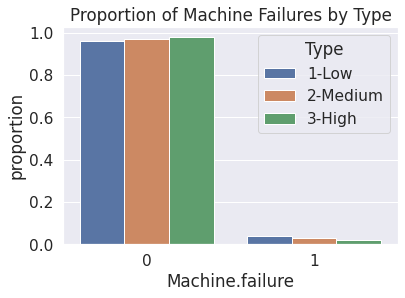

In [93]:
failure_by_type = (df[['Type', 'Machine.failure']].copy())#.groupby(['Machine.failure','Type'])
failure_by_typep = failure_by_type.pivot_table(index='Machine.failure', columns='Type', values='Type', aggfunc='size')

bp_x, bp_y, hue = 'Machine.failure', "proportion",'Type'
hue_order = ['1-Low', '2-Medium', '3-High']

bp = (failure_by_type[bp_x]
    .groupby(df[hue])
    .value_counts(normalize=True)
    .rename(bp_y)
    .reset_index()
    .pipe((sns.barplot, "data"), x=bp_x, y=bp_y, hue=hue))

legend_labels, _= bp.get_legend_handles_labels()
bp.legend(legend_labels, ['1-Low', '2-Medium', '3-High'], title='Type')
bp.set(title='Proportion of Machine Failures by Type')
plt.show()

#### Let's look at the distribution of machine failures

Text(0.5, 1.02, 'Frequency of Machine Failure and No Failure')

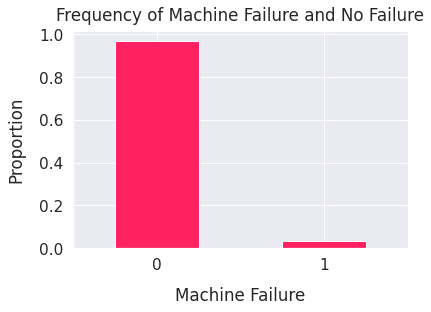

In [94]:
sns.set(font_scale=1.4)
df['Machine.failure'].value_counts(normalize=True).plot(kind='bar', figsize=(6, 4), rot=0, color='#ff2261')
plt.xlabel("Machine Failure", labelpad=14)
plt.ylabel("Proportion", labelpad=14)
plt.title("Frequency of Machine Failure and No Failure", y=1.02)

From the above barplot, we can see that our dataset is imbalanced.

## kNN

In [95]:
knn = KNeighborsClassifier(n_neighbors=5)

Use GridSearchCV to Find a good number of neighbors

{'n_neighbors': 1}


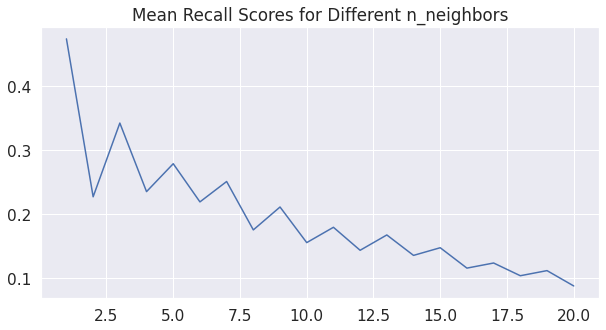

In [96]:
k_range = list(range(1, 21))
# create a parameter grid/dict: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid.fit(X_train, y_train)
# view the complete results (list of named tuples)
grid_mean_scores = grid.cv_results_["mean_test_score"]
plt.figure(figsize=(10, 5))
plt.title('Mean Recall Scores for Different n_neighbors')
plt.plot(k_range, grid_mean_scores)
print(grid.best_params_)
k = grid.best_params_['n_neighbors']

In [97]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=1)

## SVM

In [98]:
svm = SVC()
svm.fit(X_train, y_train.values.ravel())

SVC()

## RandomForestCLF

In [99]:
rfc = RandomForestClassifier(n_estimators=500, random_state=23)
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=23)

# Model Evaluation Overview
- Confusion matrix  
- Model performance comparison  
    - Accuracy  
    - Recall  

Classification Report for kNN
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.46      0.43      0.45        88

    accuracy                           0.96      2500
   macro avg       0.72      0.71      0.71      2500
weighted avg       0.96      0.96      0.96      2500


Classification Report for SVM
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2412
           1       0.90      0.22      0.35        88

    accuracy                           0.97      2500
   macro avg       0.94      0.61      0.67      2500
weighted avg       0.97      0.97      0.96      2500


Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2412
           1       0.80      0.64      0.71        88

    accuracy                           0.98      2500
   macro avg       0.89   

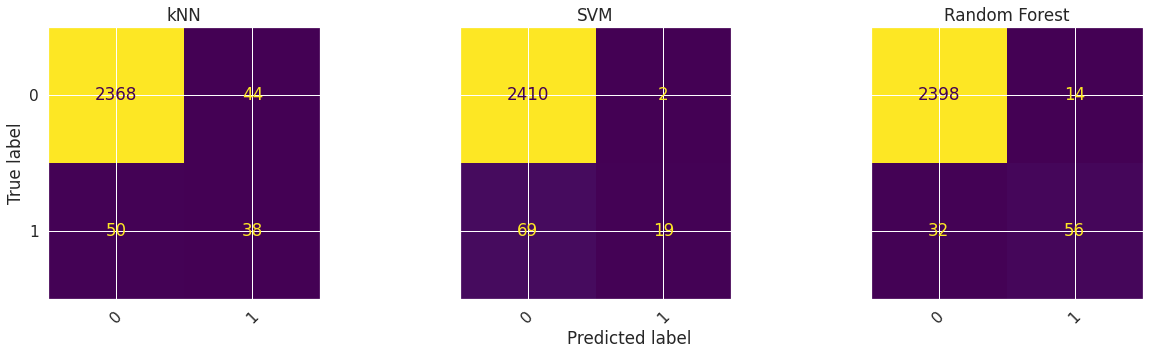

In [100]:
classifiers = {
    "kNN": knn,
    "SVM": svm,
    "Random Forest": rfc,
}

f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=['0', '1'])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
    print(f'Classification Report for {key}')
    print(classification_report(y_test, y_pred))
    print()

f.text(.5, 0, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


plt.show()

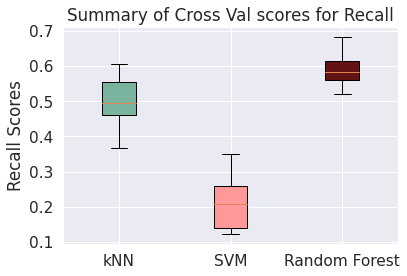

In [101]:
results = []
# Loop through the models' values
for (key, clf) in classifiers.items():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(clf, X_train, y_train, cv=kf, scoring='recall')
  results.append(cv_results)

colors = ['#7bb49e', '#ff9898', '#631314']
box = plt.boxplot(results, labels=classifiers.keys(), patch_artist=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel('Recall Scores')
plt.title('Summary of Cross Val scores for Recall')
plt.show()

# Feature Importance
- Feature importance  
    - SHAP analysis  
    - Cumulative importances

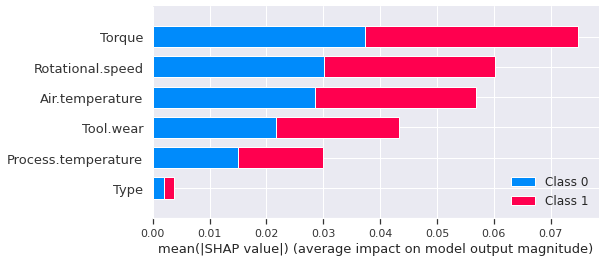

In [102]:
positive_color = "#ff9898"
negative_color = "#7bb49e"

explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X[::200])
shap.summary_plot(shap_values, X[::200])

True Class (if 1, Machine Failure, othewise No Machine Failure): 0
Probability that this data point belong to class 0 = 1.00
Base Probability for class 0 = 0.97


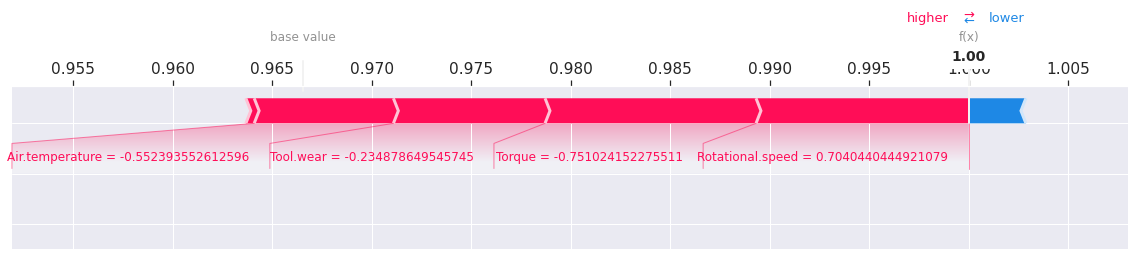

In [103]:
object_i = 33
class_object_i = int(y[::200].iloc[object_i])
print('True Class (if 1, Machine Failure, othewise No Machine Failure):', class_object_i)
print('Probability that this data point belong to class 0 = %0.2f'%(explainer.expected_value[0] + sum(shap_values[0][object_i,:])))
print('Base Probability for class 0 = %0.2f'%(explainer.expected_value[0]))

shap.force_plot(explainer.expected_value[0], 
                shap_values[0][object_i,:], 
                X.iloc[object_i,:], 
                matplotlib=True)

In [104]:
# Assign features
features = df.drop(['UDI', 'Machine.failure'], axis = 1)
feature_list = list(features.columns)
# Get numerical feature importances
importances = list(RFC.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Torque               Importance: 0.47
Variable: Rotational.speed     Importance: 0.3
Variable: Tool.wear            Importance: 0.13
Variable: Air.temperature      Importance: 0.06
Variable: Process.temperature  Importance: 0.03
Variable: Type                 Importance: 0.01


[None, None, None, None, None, None]

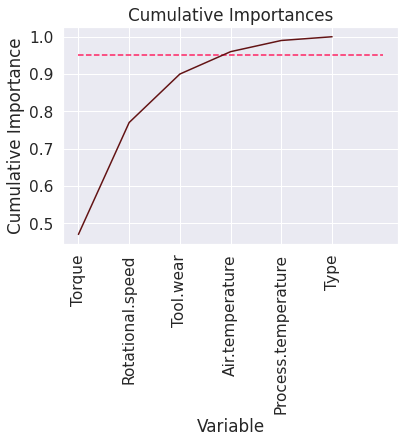

In [105]:
# List features by importance
x_values = list(range(len(importances)))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, '#631314')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = '#ff2261', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');